# **0. Setup**

## 0.1. Library and Environment

In [ ]:
!pip -U install pandas matplotlib yfinance seaborn plotly alpha_vantage python-dotenv nbformat statsmodels scikit-learn

In [11]:
import os
import re
import math
import numpy as np
import pandas as pd
from dotenv import load_dotenv # type: ignore

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats

np.random.seed(42)
pd.set_option("display.max_columns", None)

FIG_DIR = "fig"
TICKER = "^GSPC"
START_DATE = "1900-01-01"
END_DATE = "2025-01-01"
INTERVAL = "1D"

load_dotenv()
ALPHA_VANTAGE_API_KEY = os.getenv("ALPHA_VANTAGE_API_KEY_2")

MACRO_ECONOMICS_INDICATORS = ["VIXY", "IEF", "UUP", "USO", "GLD", "CPI"]


## 0.2. Data Crawling & Processing

### 0.2.1. OHLCV

In [20]:
# OHLCV downloading
raw_data = yf.download(
    tickers = TICKER,
    start = START_DATE,
    end = END_DATE,
    interval = INTERVAL,
    progress = False,
    auto_adjust = True
)

# Columns name preprocessing
def col_preprocess(df):
    df_tmp = df.copy()
    df_tmp.columns = df_tmp.columns.get_level_values(0)
    df_tmp = df_tmp[['Open', 'High', 'Low', 'Close', 'Volume']]
    df_tmp.reset_index(inplace=True)
    df_tmp.columns.name = None
    df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
    return df_tmp

ohlcv = col_preprocess(raw_data)
ohlcv.to_csv("data/GSPC.csv")
ohlcv

,Date,Open,High,Low,Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...
24362,2024-12-24,5984.629883,6040.100098,5981.439941,6040.040039,1757720000
24363,2024-12-26,6024.970215,6049.750000,6007.370117,6037.589844,2904530000
24364,2024-12-27,6006.169922,6006.169922,5932.950195,5970.839844,3159610000
24365,2024-12-30,5920.669922,5940.790039,5869.160156,5906.939941,3433250000


### 0.2.2. Macroeconomics

In [22]:
def get_indicator(symbol, start, end):
    ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')
    data, meta = ts.get_daily(symbol=symbol, outputsize='full')
    data = data.rename(columns={'1. open': 'Open'})
    data = data.rename(columns={'2. high': 'High'})
    data = data.rename(columns={'3. low': 'Low'})
    data = data.rename(columns={'4. close': 'Close'})
    data = data.rename(columns={'5. volume': 'Volume'})
    data.index = pd.to_datetime(data.index)
    data = data.loc[(data.index >= start) & (data.index <= end)]

    data = data.sort_index(ascending=True)
    data = data.reset_index()
    if 'index' in data.columns:
        data = data.rename(columns={'index': 'Date'})
    elif 'date' in data.columns:
        data = data.rename(columns={'date': 'Date'})
    else:
        data['Date'] = data.index

    return data

for sym in MACRO_ECONOMICS_INDICATORS:
    try:
        ind = get_indicator(sym, START_DATE, END_DATE)
        ind.to_csv(f"data/{sym}.csv")
        print(f"Downloaded {sym}")
        # break
    except Exception as e:
        print(f"Error when download {sym}: {e}")

Downloaded VIXY
Downloaded IEF
Error when download UUP: We have detected your API key as A1AHKBYRATJ0YIKH and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.
Error when download USO: We have detected your API key as A1AHKBYRATJ0YIKH and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.
Error when download GLD: We have detected your API key as A1AHKBYRATJ0YIKH and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.alphavantage.co/premium/ to instantly remove all daily rate limits.
Error when download CPI: We have detected your API key as A1AHKBYRATJ0YIKH and our standard API rate limit is 25 requests per day. Please subscribe to any of the premium plans at https://www.a

# **1. EDA**

## a. Data Summary

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3518 entries, 0 to 3517
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         3518 non-null   datetime64[ns]
 1   Open         3518 non-null   float64       
 2   High         3518 non-null   float64       
 3   Low          3518 non-null   float64       
 4   Close        3518 non-null   float64       
 5   Volume       3518 non-null   int64         
 6   VIX          3518 non-null   float64       
 7   US10Y        3518 non-null   float64       
 8   DXY          3518 non-null   float64       
 9   OIL          3518 non-null   float64       
 10  GOLD         3518 non-null   float64       
 11  CPI_US       3518 non-null   float64       
 12  MA_20        3518 non-null   float64       
 13  EMA_20       3518 non-null   float64       
 14  MAE_20       3518 non-null   float64       
 15  MA_60        3518 non-null   float64       
 16  EMA_60     

In [62]:
print(f"Null value check: \n{(data == 0).sum()}")

Null value check: 
Date              0
Open              0
High              0
Low               0
Close             0
Volume         1624
VIX               0
US10Y             0
DXY               0
OIL               0
GOLD              0
CPI_US            0
MA_20             0
EMA_20            0
MAE_20            0
MA_60             0
EMA_60            0
MAE_60            0
MA_120            0
EMA_120           0
MAE_120           0
MA_360            0
EMA_360           0
MAE_360           0
MACD              0
MACD_long         0
Signal            0
Signal_long       0
RSI_7            13
RSI_14            0
RSI_28            0
RSI_56            0
dtype: int64


In [48]:
print(f"Null value check: \n{data.isna().sum()}")

Null value check: 
Date           0
Open           0
High           0
Low            0
Close          0
Volume         0
VIX            0
US10Y          0
DXY            0
OIL            0
GOLD           0
CPI_US         0
MA_20          0
EMA_20         0
MAE_20         0
MA_60          0
EMA_60         0
MAE_60         0
MA_120         0
EMA_120        0
MAE_120        0
MA_360         0
EMA_360        0
MAE_360        0
MACD           0
MACD_long      0
Signal         0
Signal_long    0
RSI_7          0
RSI_14         0
RSI_28         0
RSI_56         0
dtype: int64


In [49]:
duplicate_count = data.duplicated().sum()
print(f"Duplicate rows: {duplicate_count}")

Duplicate rows: 0


## b. Statistical Analysis

In [51]:
def statistical_analysis(df: pd.DataFrame) -> dict:
    result = {
        "mean": df.mean(),
        "median": df.median(),
        "std": df.std(),
        "min": df.min(),
        "max": df.max(),
        "q1": df.quantile(0.25),
        "q3": df.quantile(0.75),
        "iqr": df.quantile(0.75) - df.quantile(0.25)
    }

    return result

stats_summary = pd.DataFrame({
    col: statistical_analysis(data[col])
    for col in data.select_dtypes(include=['number']).columns
})
stats_summary = stats_summary.round(3)

In [52]:
stats_summary

,Open,High,Low,Close,Volume,VIX,US10Y,DXY,OIL,GOLD,CPI_US,MA_20,EMA_20,MAE_20,MA_60,EMA_60,MAE_60,MA_120,EMA_120,MAE_120,MA_360,EMA_360,MAE_360,MACD,MACD_long,Signal,Signal_long,RSI_7,RSI_14,RSI_28,RSI_56
mean,416.460,419.611,413.316,416.580,1.197605e+08,25.289,105.360,25.018,35.073,148.543,26.581,414.967,414.952,3.721,411.458,411.563,3.700,406.577,406.889,3.670,389.970,391.249,3.605,1.216,4.674,1.222,4.497,54.519,54.384,54.048,53.565
median,406.690,410.020,403.310,406.745,4.748800e+06,20.470,105.330,25.060,33.615,143.880,26.592,405.914,406.050,3.040,403.903,404.316,3.134,401.434,406.148,3.199,391.161,397.453,2.794,1.487,4.075,1.466,4.068,54.872,54.428,54.347,53.652
std,156.522,157.566,155.480,156.526,1.629818e+08,17.136,7.295,2.384,22.895,31.642,0.872,155.199,155.028,2.481,152.336,152.175,2.126,148.997,148.740,1.912,139.864,140.069,1.657,6.036,11.229,5.652,10.350,22.756,16.284,11.289,7.806
min,151.730,158.000,147.660,153.900,0.000000e+00,5.250,88.950,20.930,2.130,100.500,23.920,162.902,163.194,0.620,169.175,172.084,1.232,172.689,177.769,1.410,192.139,191.194,1.676,-47.619,-31.174,-41.029,-25.387,0.000,2.187,21.404,29.466
max,854.250,857.110,851.290,851.980,1.335046e+09,121.950,123.060,30.670,91.990,257.500,28.520,835.314,830.506,24.300,806.953,802.999,14.902,769.021,774.447,10.774,674.712,698.742,7.110,18.004,36.936,16.728,34.841,100.000,96.629,85.734,76.278
q1,297.875,299.688,295.830,297.968,0.000000e+00,14.050,101.270,22.710,12.740,121.332,25.890,297.001,296.699,2.054,295.947,296.946,2.085,296.267,296.460,2.170,276.167,275.185,2.400,-1.243,-0.311,-0.961,-0.746,37.602,43.066,46.147,48.650
q3,537.518,543.133,533.512,537.650,2.544945e+08,29.545,109.300,26.470,47.795,169.505,27.345,539.543,540.550,4.767,546.192,546.999,4.893,548.107,552.929,4.807,468.333,505.664,5.229,4.166,9.681,3.857,9.171,71.842,66.225,62.215,58.706
iqr,239.643,243.445,237.682,239.682,2.544945e+08,15.495,8.030,3.760,35.055,48.172,1.455,242.541,243.850,2.713,250.245,250.053,2.808,251.840,256.469,2.637,192.166,230.480,2.829,5.410,9.993,4.818,9.917,34.240,23.159,16.068,10.056


In [53]:
stats_summary.T.to_csv("statistical_summary.csv", index=True)


## c. Visualization

### c.1. Candlestick Chart

In [54]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Candlestick(
        x=data['Date'],
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Price'
    ),
    secondary_y=True
)

fig.add_trace(
    go.Bar(
        x=data['Date'],
        y=data['Volume'],
        name='Volume',
        marker_color='blue',
        opacity=0.4
    ),
    secondary_y=False
)

fig.update_yaxes(showgrid=False, secondary_y=True)
fig.update_layout(
    title='S&P 500 Financials (Sector) (^SP500-40)',
    xaxis_title='Date',
    yaxis_title='Volume',
    yaxis2_title='Index',
    xaxis_rangeslider_visible=False,
    template='seaborn',
    width=2000,
    height=600,
)

fig.show()

### c.2. Boxplot

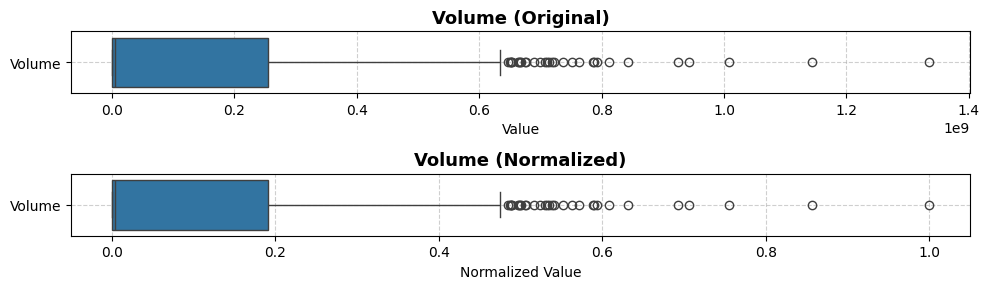

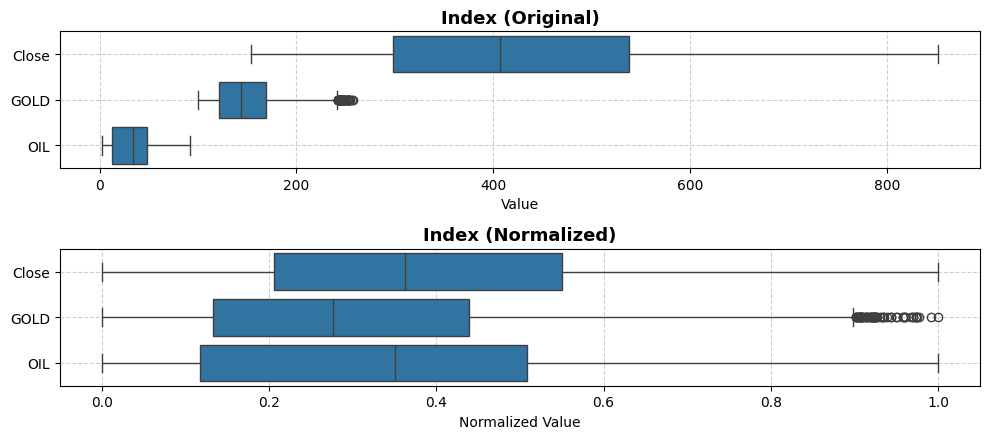

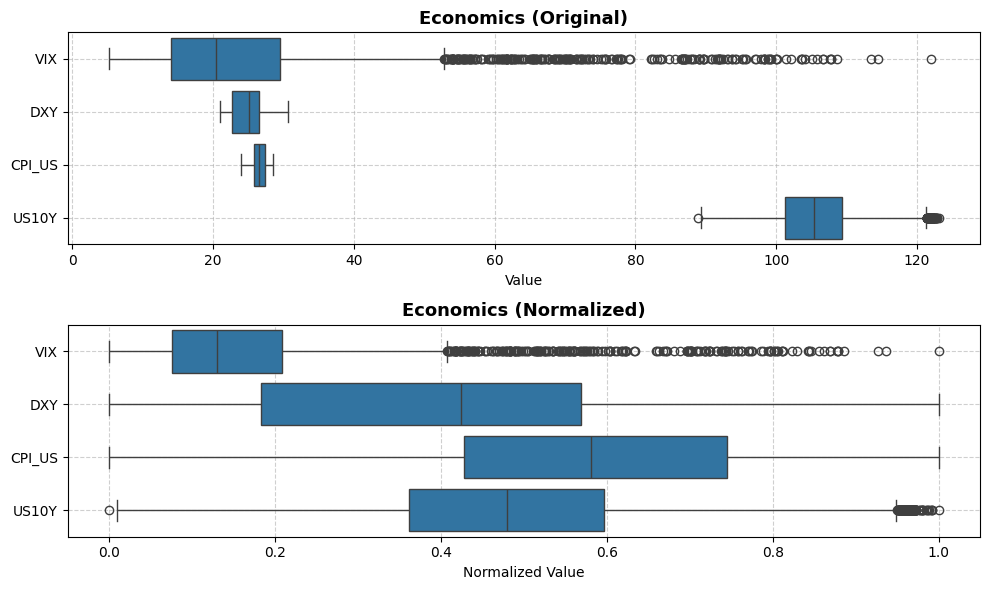

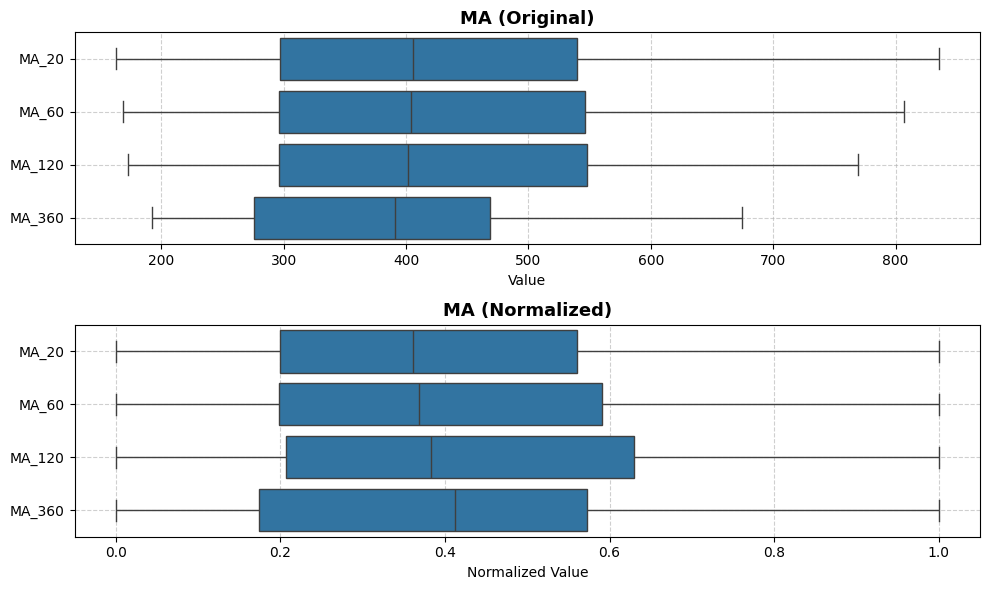

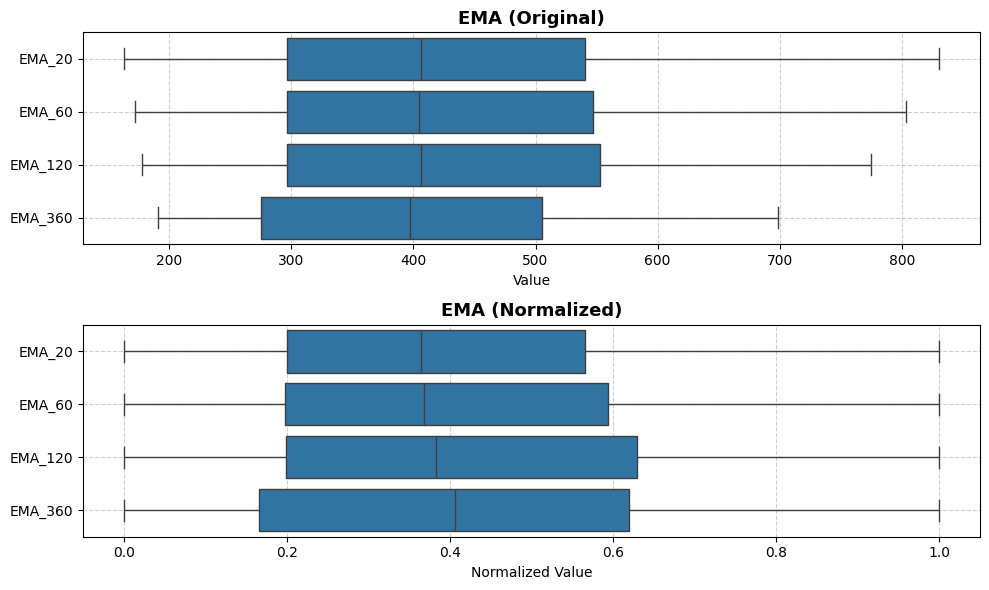

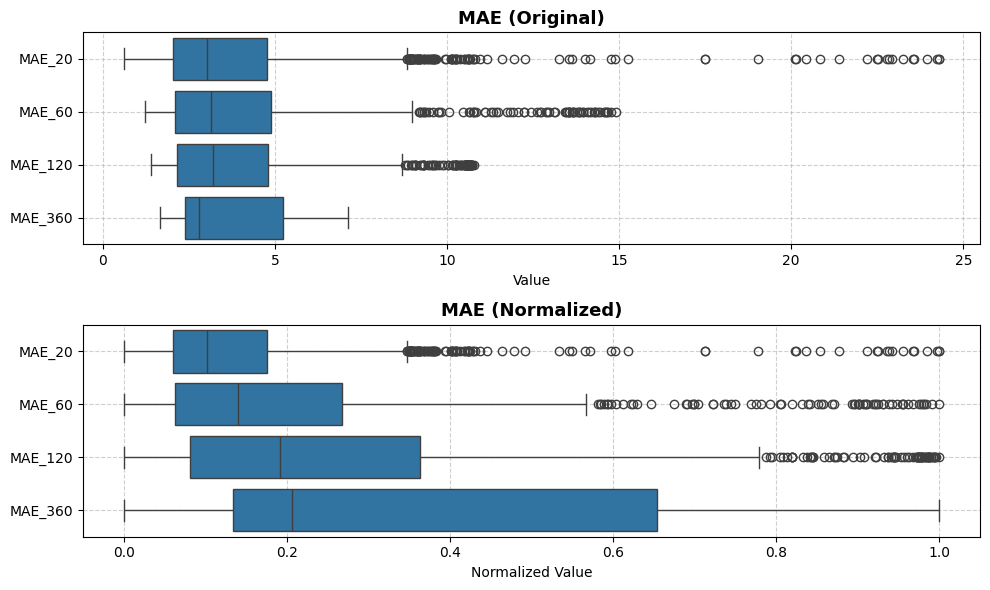

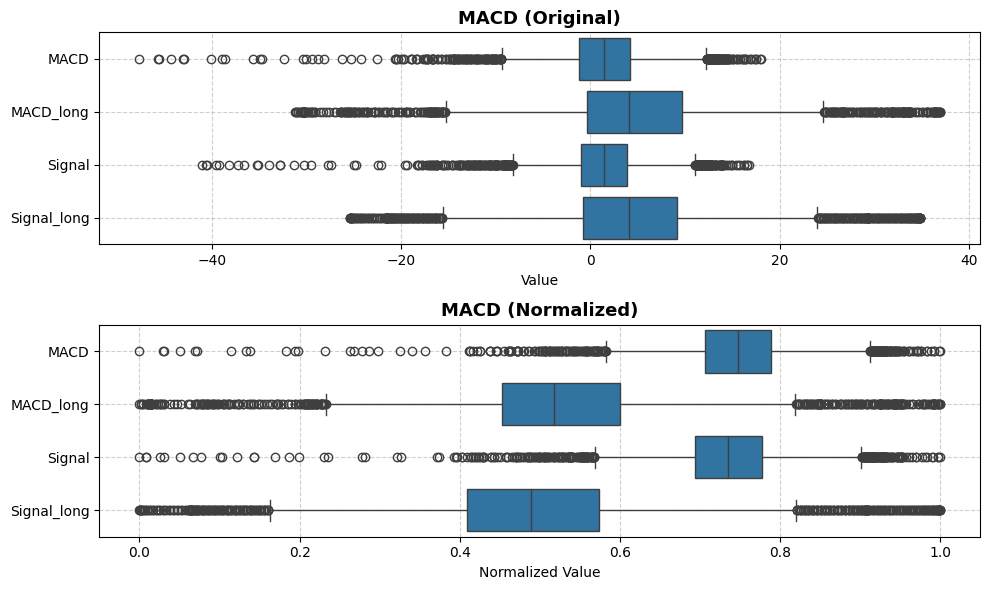

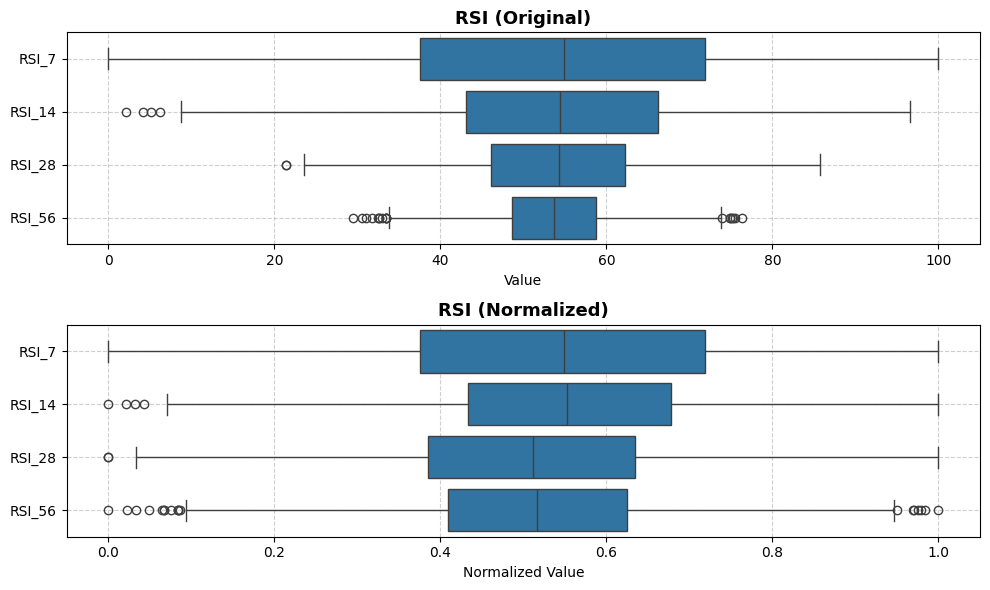

In [ ]:
groups = {
    "Volume": ["Volume"],
    "Index": ["Close", "Volume", 'GOLD', "OIL"],
    'Economics': [ 'VIX', 'DXY', 'CPI_US', 'US10Y'],
    "MA": ['MA_20', 'MA_60', 'MA_120', 'MA_360'],
    "EMA": ['EMA_20', 'EMA_60', 'EMA_120', 'EMA_360'],
    "MAE": ['MAE_20', 'MAE_60', 'MAE_120', 'MAE_360',],
    "MACD": ['MACD', 'MACD_long', 'Signal', 'Signal_long'],
    "RSI": ['RSI_7', 'RSI_14', 'RSI_28', 'RSI_56']
}

for title, cols_in_group in groups.items():
    if len(cols_in_group) == 1:
        w = 3
    else:
        w = 1.5 * len(cols_in_group)
    fig, axes = plt.subplots(2, 1, figsize=(10, w))

    # --- Original Data ---
    data_melted = data.melt(
        value_vars=cols_in_group,
        var_name="Value Type",
        value_name="Value"
    )
    sns.boxplot(
        y="Value Type",  # vì orient='h'
        x="Value",
        data=data_melted,
        order=cols_in_group,
        ax=axes[0],
        orient='h'
    )
    axes[0].set_title(f"{title} (Original)", fontsize=13, fontweight='bold')
    axes[0].set_xlabel("Value")
    axes[0].set_ylabel("")
    axes[0].grid(True, linestyle="--", alpha=0.6)

    # --- Normalized Data ---
    scaler = MinMaxScaler()
    data_norm = pd.DataFrame(
        scaler.fit_transform(data[cols_in_group]),
        columns=cols_in_group,
        index=data.index
    )
    data_norm_melted = data_norm.melt(
        value_vars=cols_in_group,
        var_name="Value Type",
        value_name="Value"
    )
    sns.boxplot(
        y="Value Type",
        x="Value",
        data=data_norm_melted,
        order=cols_in_group,
        ax=axes[1],
        orient='h'
    )
    axes[1].set_title(f"{title} (Normalized)", fontsize=13, fontweight='bold')
    axes[1].set_xlabel("Normalized Value")
    axes[1].set_ylabel("")
    axes[1].grid(True, linestyle="--", alpha=0.6)

    # --- Layout & Save ---
    plt.tight_layout()
    save_path = os.path.join(FIG_DIR, f"boxplot_{title.replace(' ', '_')}_compare.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

### c.3. Histogram

In [59]:
print(data[data['Volume'] == 0])

           Date        Open        High         Low       Close  Volume  \
510  2013-01-15  230.970001  230.970001  230.970001  230.970001       0   
511  2013-01-16  231.250000  231.250000  231.250000  231.250000       0   
512  2013-01-17  231.009995  231.009995  231.009995  231.009995       0   
513  2013-01-18  231.350006  231.350006  231.350006  231.350006       0   
514  2013-01-22  233.429993  233.429993  233.429993  233.429993       0   
...         ...         ...         ...         ...         ...     ...   
2169 2019-08-22  440.320007  444.619995  440.109985  443.070007       0   
2170 2019-08-23  443.070007  443.480011  429.309998  431.839996       0   
2171 2019-08-26  431.839996  436.619995  431.839996  436.500000       0   
2172 2019-08-27  436.500000  439.179993  431.200012  433.459991       0   
2515 2021-01-06  506.779999  506.779999  506.779999  506.779999       0   

        VIX   US10Y    DXY    OIL     GOLD   CPI_US       MA_20      EMA_20  \
510   13.94  107.13 

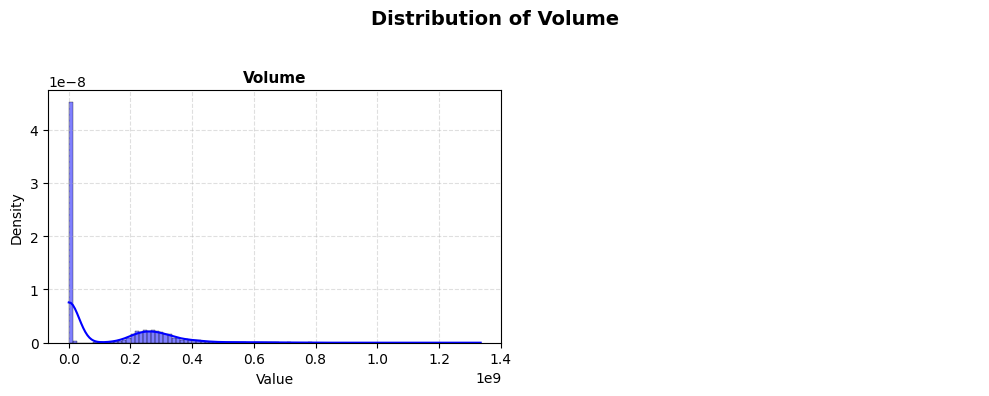

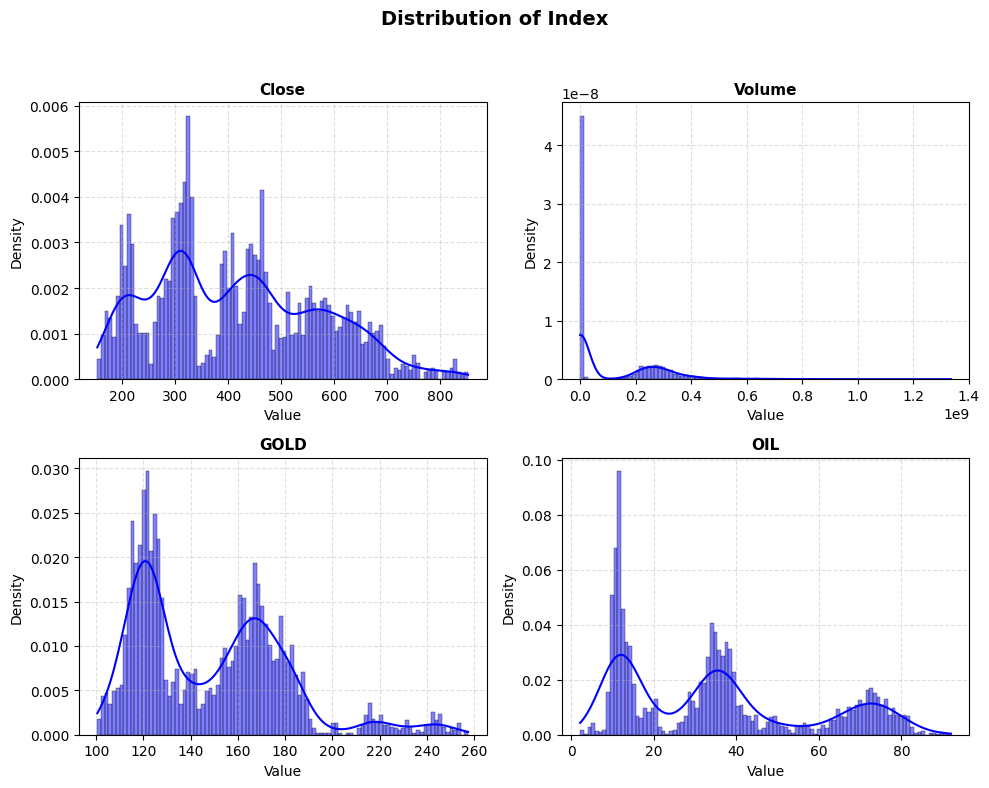

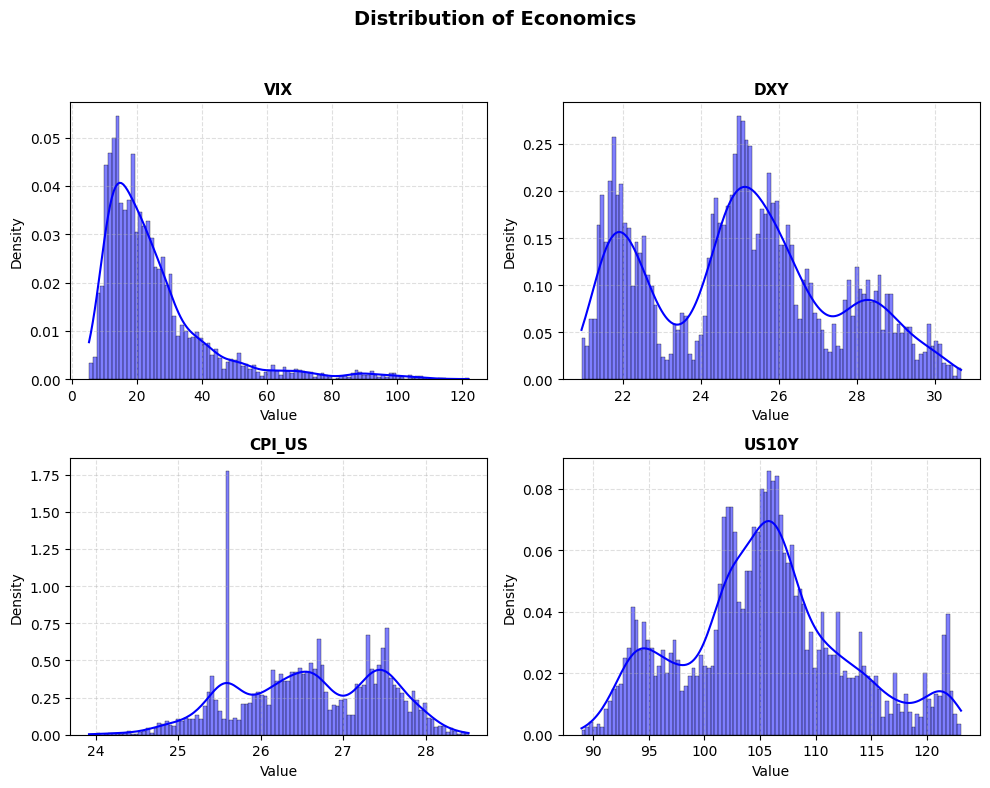

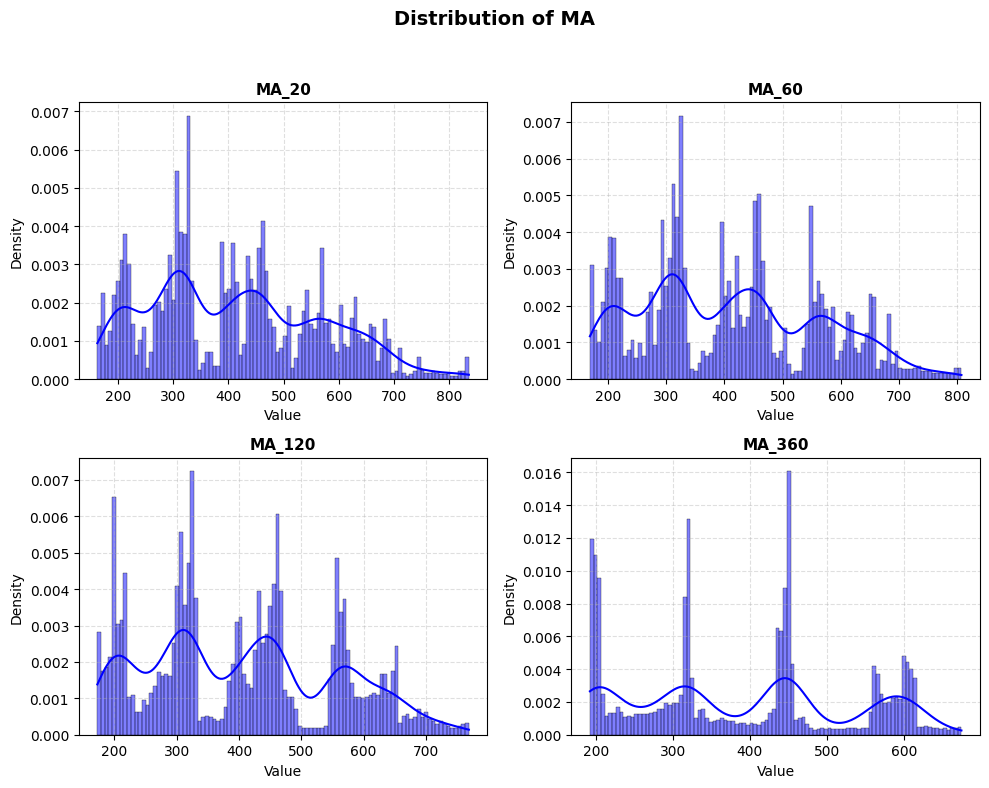

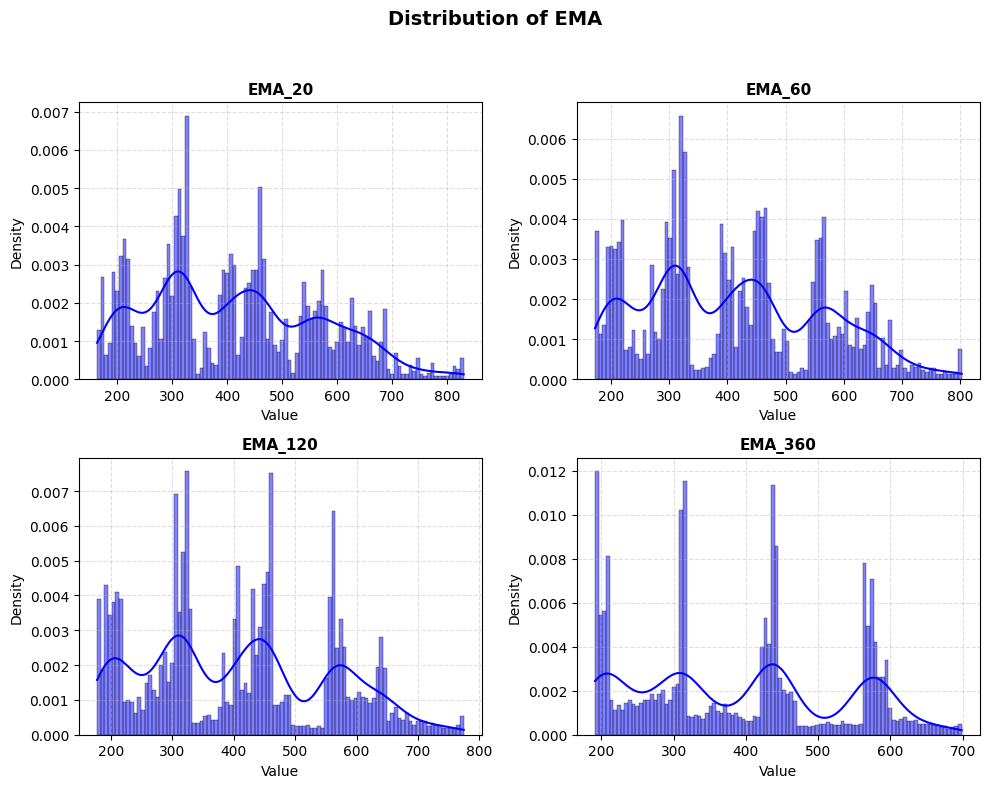

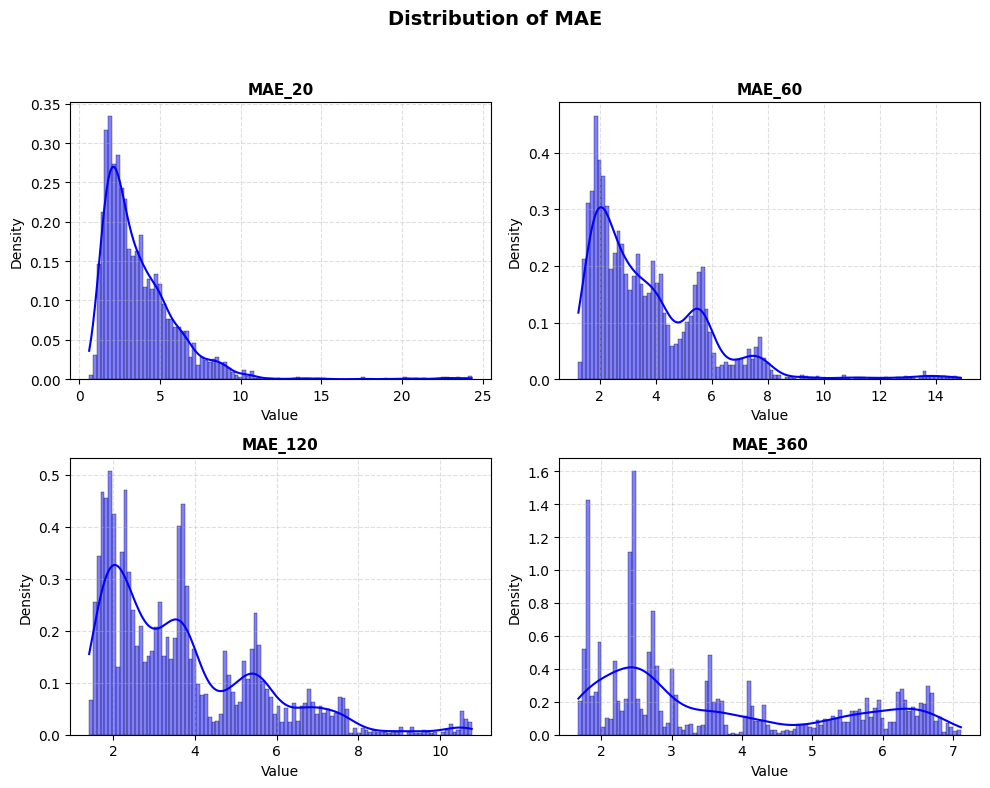

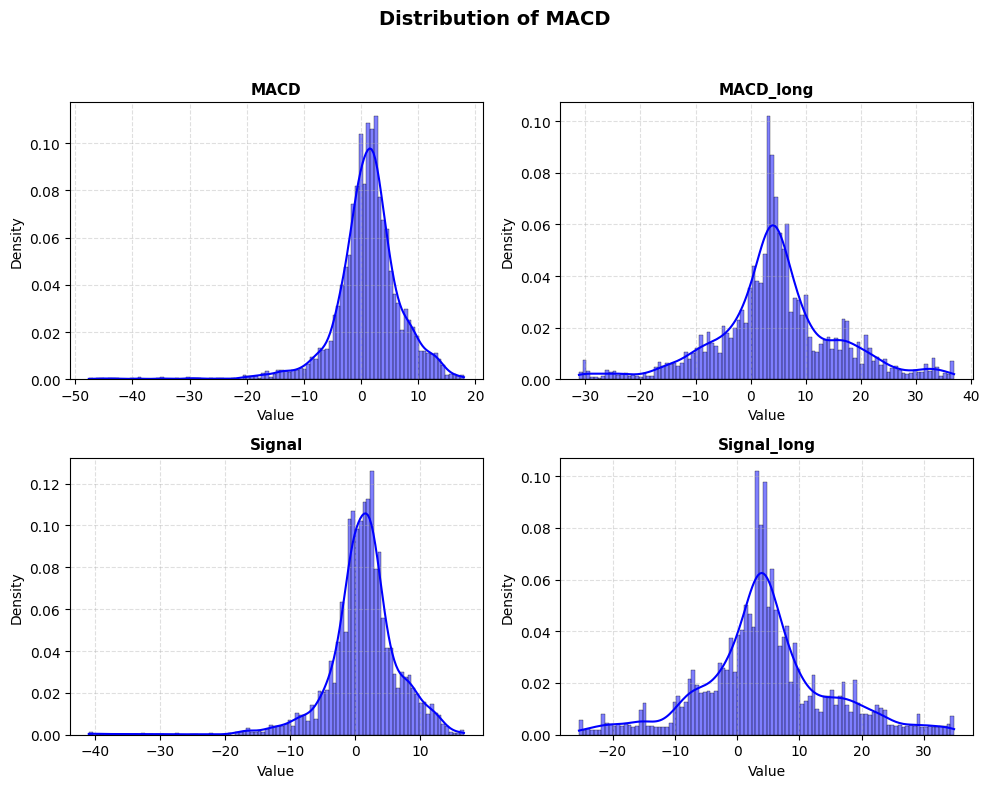

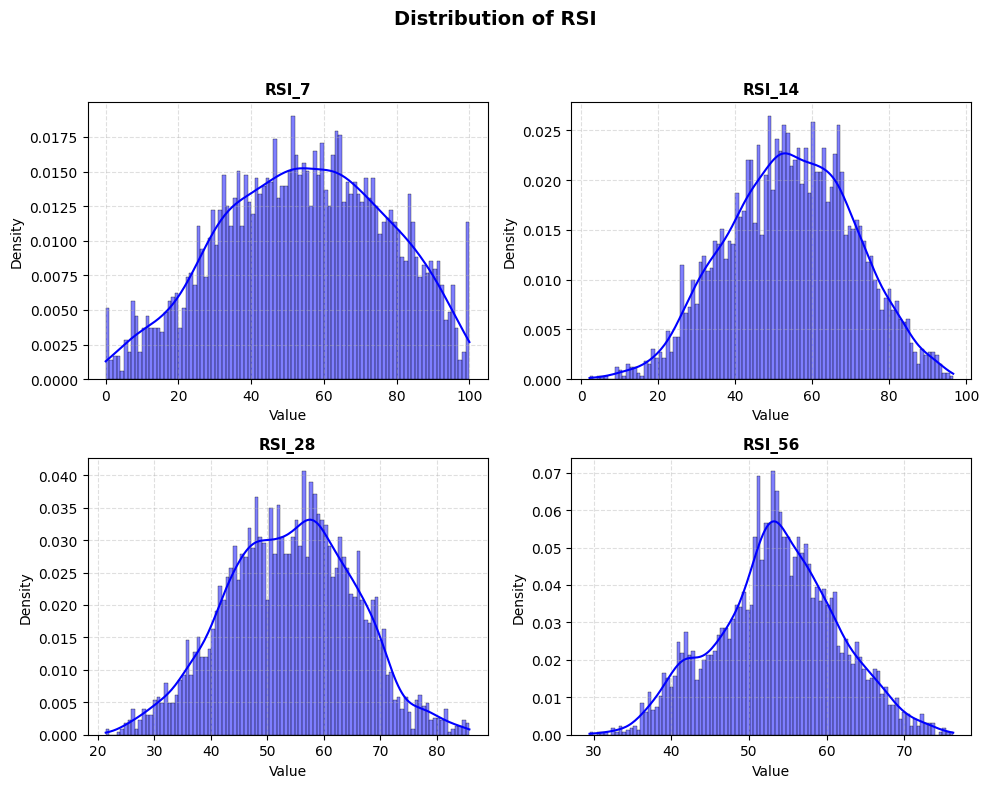

In [60]:
groups = {
    "Volume": ["Volume"],
    "Index": ["Close", "Volume", 'GOLD', "OIL"],
    'Economics': [ 'VIX', 'DXY', 'CPI_US', 'US10Y'],
    "MA": ['MA_20', 'MA_60', 'MA_120', 'MA_360'],
    "EMA": ['EMA_20', 'EMA_60', 'EMA_120', 'EMA_360'],
    "MAE": ['MAE_20', 'MAE_60', 'MAE_120', 'MAE_360',],
    "MACD": ['MACD', 'MACD_long', 'Signal', 'Signal_long'],
    "RSI": ['RSI_7', 'RSI_14', 'RSI_28', 'RSI_56']
}
max_cols = 2
for title, cols_in_group in groups.items():
    n = len(cols_in_group)
    n_rows = math.ceil(n / max_cols)

    fig, axes = plt.subplots(n_rows, max_cols, figsize=(5*max_cols, 4*n_rows))
    axes = axes.flatten()

    for i, col in enumerate(cols_in_group):
        sns.histplot(
            data[col].dropna(),
            kde=True,
            stat="density",
            bins=100,
            color="blue",
            ax=axes[i]
        )
        axes[i].set_title(f"{col}", fontsize=11, fontweight='bold')
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Density")
        axes[i].grid(True, linestyle="--", alpha=0.4)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"Distribution of {title}", fontsize=14, fontweight='bold')
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    save_path = os.path.join(FIG_DIR, f"group_hist_{title.replace(' ', '_')}.png")
    plt.savefig(save_path, dpi=150)
    plt.show()
    plt.close()

### c.4. Line Chart

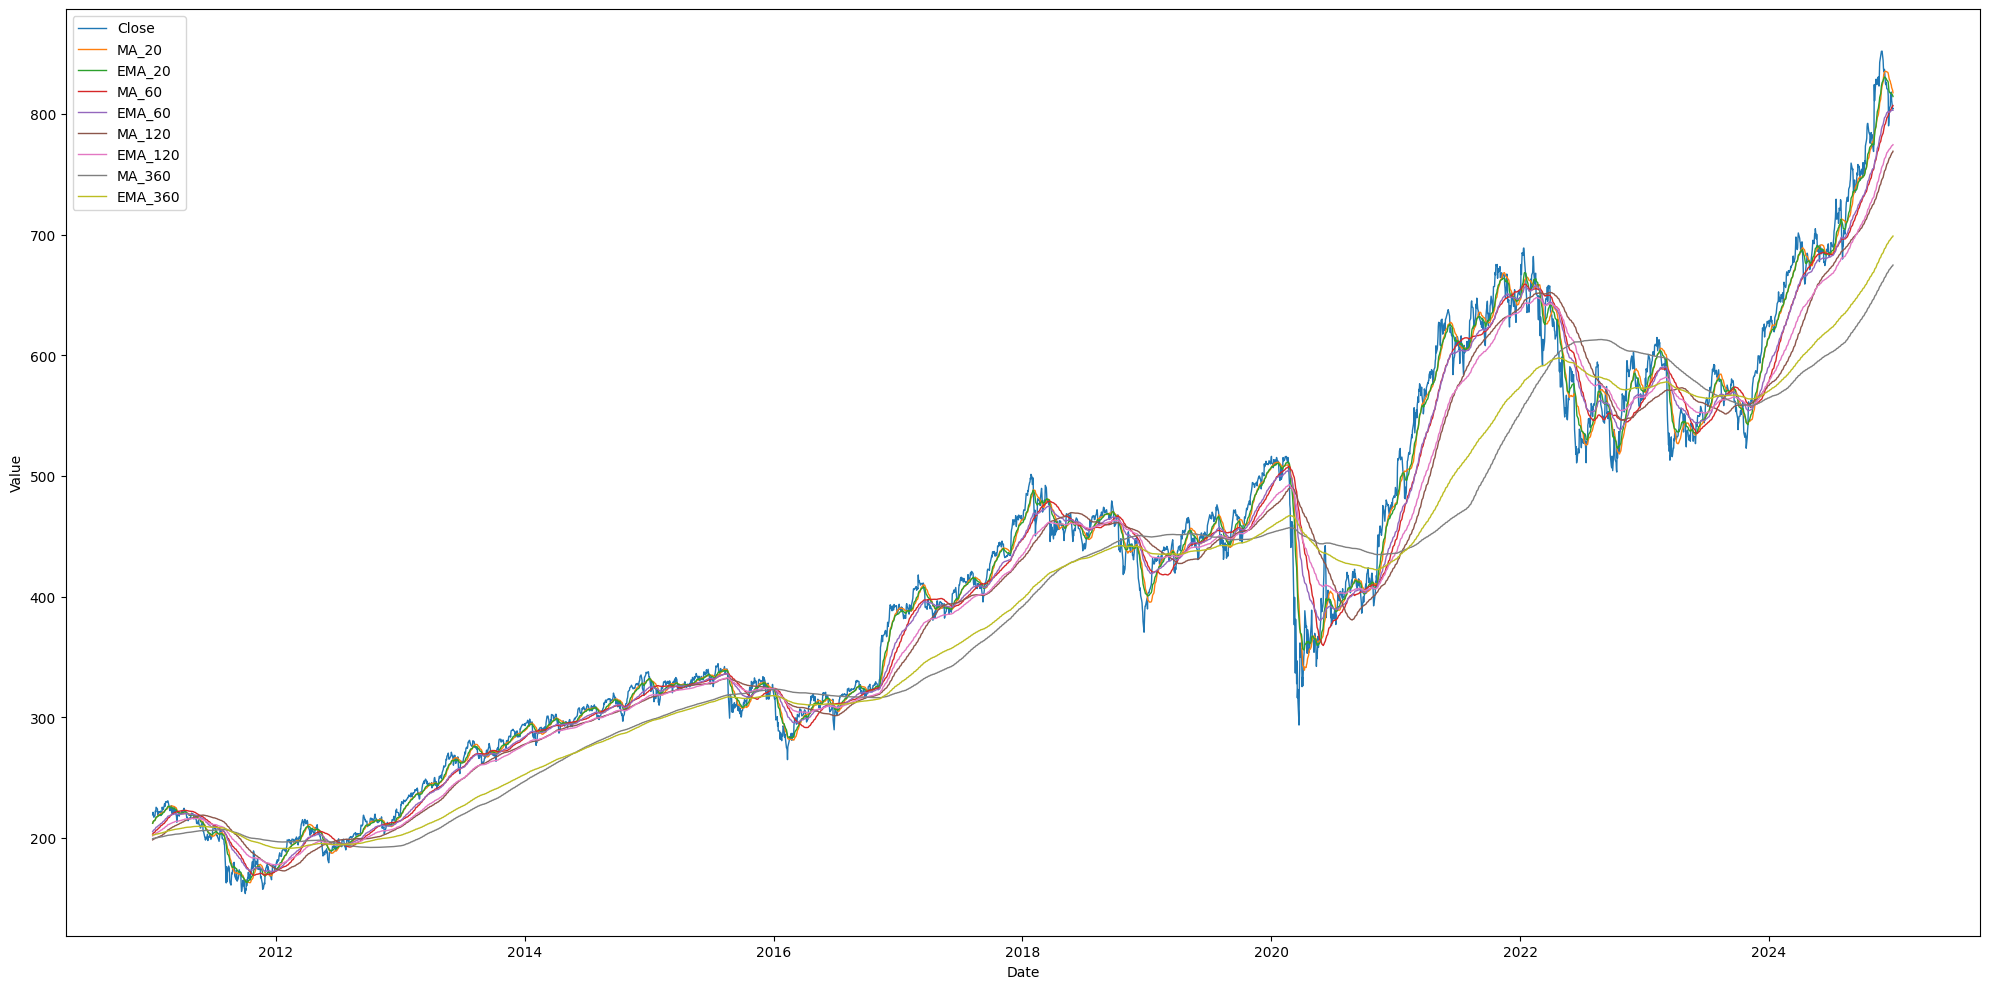

In [ ]:
groups = {
    # 'Kinh te': ['DXY', 'CPI_US'],
    "MA & EMA": ["Close", 'MA_20', 'EMA_20', 'MA_60', 'EMA_60', 'MA_120', 'EMA_120', 'MA_360', 'EMA_360'],
    # "MAE": ['MAE_20', 'MAE_60', 'MAE_120', 'MAE_360',],
    # "MACD": ['MACD', 'MACD_long', 'Signal', 'Signal_long'],
    # "RSI": ['RSI', 'RSI_7', 'RSI_14', 'RSI_28']
}

plt.figure(figsize=(20,10))

for title, cols_in_group in groups.items():
    for col in cols_in_group:
        plt.plot(data["Date"], data[col], label=f"{col}", linewidth=1)

plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()
# line_path = os.path.join(FIG_DIR, "line_trend.png")
# plt.savefig(line_path, dpi=150)
plt.close()

### c.5. Heatmap

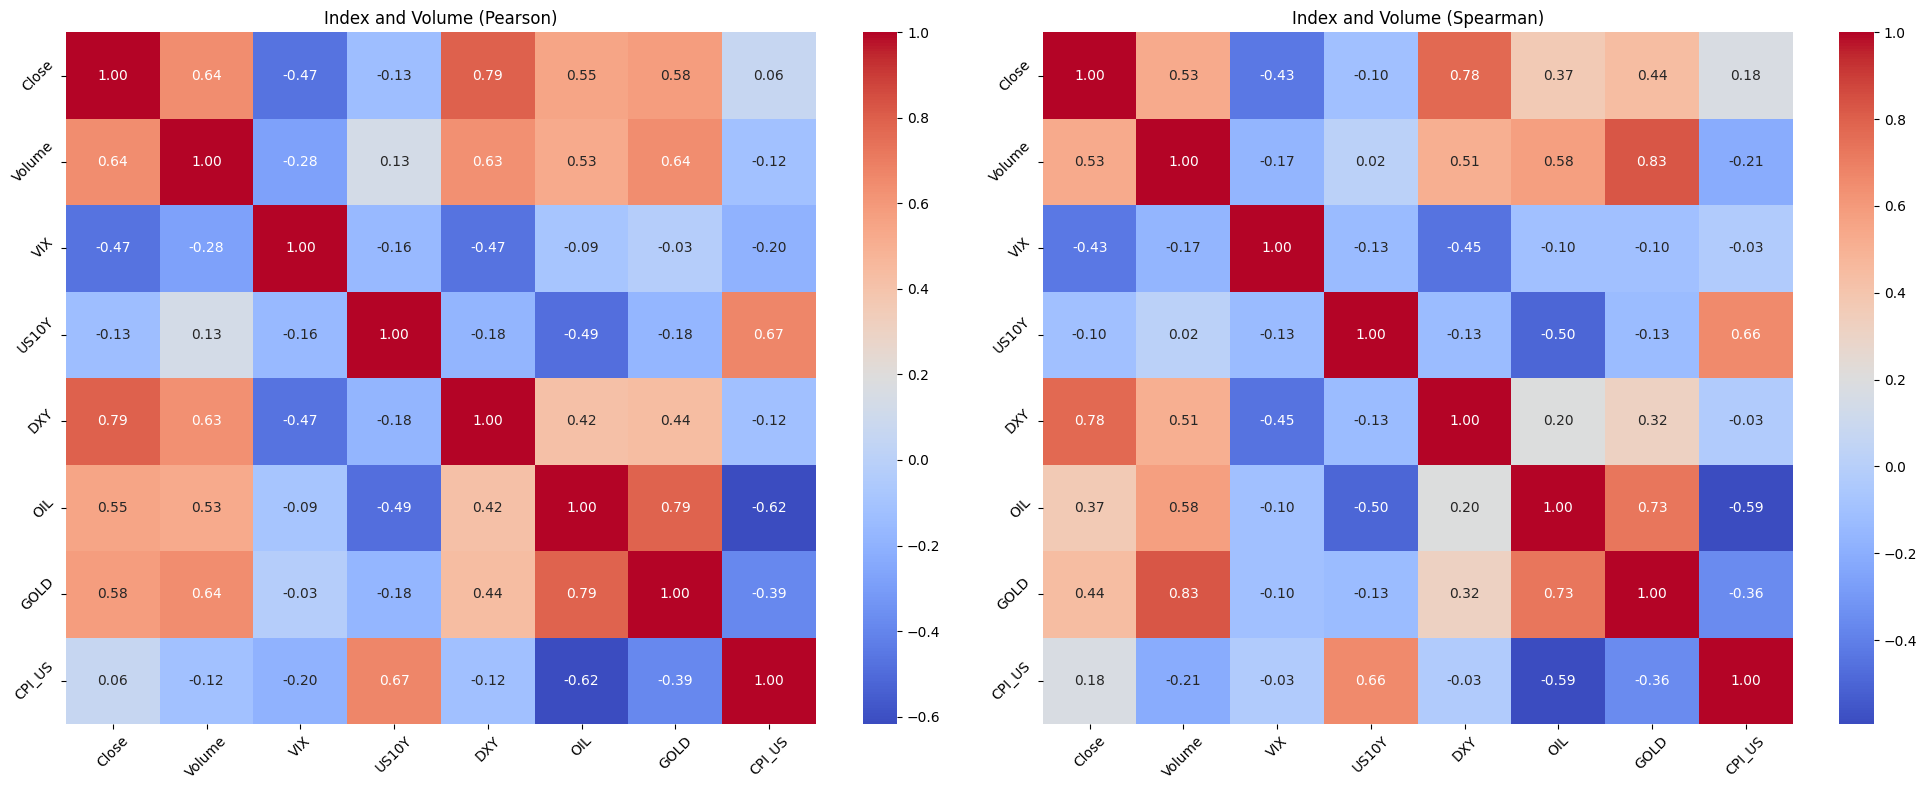

In [ ]:
corr_pear = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD', "CPI_US"
    ]
].corr(method="pearson")

corr_spear = data[[
        'Close', 'Volume', 'VIX', 'US10Y', 'DXY', 'OIL', 'GOLD', "CPI_US"
    ]
].corr(method="spearman")

plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.heatmap(corr_pear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Pearson)")

plt.subplot(1, 2, 2)
sns.heatmap(corr_spear, annot=True, cmap="coolwarm", fmt=".2f")
plt.yticks(rotation=(45))
plt.xticks(rotation=(45))
plt.title("Index and Volume (Spearman)")

plt.tight_layout()
plt.show()

## d. Anomaly detection

In [ ]:
def detect_outliers_zscore(df, cols=None, z_thresh=3.0):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = pd.DataFrame(False, index=df.index, columns=cols)
    for c in cols:
        vals = df[c].values
        z = np.abs(stats.zscore(vals, nan_policy='omit'))
        mask = np.zeros_like(z, dtype=bool)
        mask[~np.isnan(z)] = z[~np.isnan(z)] > z_thresh
        out[c] = mask
    return out

def detect_outliers_iqr(df, cols=None, k=1.5):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = pd.DataFrame(False, index=df.index, columns=cols)
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        out[c] = (df[c] < lower) | (df[c] > upper)
    return out

In [ ]:
def detect_outliers_rolling(df, col='Close', window=20, z_thresh=3.0, min_periods=None):
    if min_periods is None:
        min_periods = max(3, window//2)
    roll_mean = df[col].rolling(window=window, min_periods=min_periods, center=False).mean()
    roll_std  = df[col].rolling(window=window, min_periods=min_periods, center=False).std()
    z = (df[col] - roll_mean) / (roll_std + 1e-12)
    mask = z.abs() > z_thresh
    res = pd.Series(False, index=df.index, name=f'rolling_{col}')
    res[mask.fillna(False)] = True
    return res, roll_mean, roll_std

In [ ]:
def detect_outliers_decompose(df, col='Close', model='additive', period=None, z_thresh=3.0):
    if period is None:
        period = 252 if df.shape[0] > 300 else None

    if period is None:
        raise ValueError("Need to pass period for seasonal_decompose with short window. E.g.: period=7,30,252 ...")

    decomp = seasonal_decompose(df[col].dropna(), model=model, period=period, extrapolate_trend='freq')
    resid = decomp.resid.reindex(df.index)  # align
    z = (resid - resid.mean()) / (resid.std(ddof=0) + 1e-12)
    mask = z.abs() > z_thresh
    return mask.fillna(False), decomp


In [ ]:
def detect_outliers_arima_residuals(df, col='Close', order=(1,1,1), z_thresh=3.0, enforce_stationarity=False, enforce_invertibility=False):
    series = df[col].dropna()
    try:
        model = ARIMA(series, order=order, enforce_stationarity=enforce_stationarity, enforce_invertibility=enforce_invertibility)
        res = model.fit()
        resid = res.resid.reindex(df.index)
        z = (resid - resid.mean()) / (resid.std(ddof=0) + 1e-12)
        mask = z.abs() > z_thresh
        return mask.fillna(False), res
    except Exception as e:
        print("ARIMA fitting failed:", e)
        return pd.Series(False, index=df.index), None


In [ ]:
def detect_outliers_isolationforest(df, feature_cols=None, contamination=0.01, random_state=42):
    if feature_cols is None:
        feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    X = df[feature_cols].copy()
    X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)
    sc = StandardScaler()
    Xs = sc.fit_transform(X)
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    iso.fit(Xs)
    preds = iso.predict(Xs)
    mask = pd.Series(preds == -1, index=df.index)
    scores = pd.Series(iso.decision_function(Xs), index=df.index)
    return mask, scores


In [ ]:
def aggregate_outliers(df, methods_dict):
    out_df = pd.DataFrame(index=df.index)
    for name, mask in methods_dict.items():
        out_df[name] = mask.astype(bool)
    out_df['any_outlier'] = out_df.any(axis=1)
    out_df['n_methods_flagged'] = out_df.drop(columns=['any_outlier']).sum(axis=1)
    return out_df


In [ ]:
def plot_time_series_with_flags(df, col='Close', agg_flags=None, title=None, figsize=(20,6)):
    plt.figure(figsize=figsize)
    plt.plot(df.index, df[col], label=col, color='blue', linewidth=1)

    if agg_flags is not None and 'n_methods_flagged' in agg_flags.columns:
        flagged_pts = df.loc[agg_flags['n_methods_flagged'] > 0, col]
        n_flags = agg_flags.loc[agg_flags['n_methods_flagged'] > 0, 'n_methods_flagged']

        sizes = n_flags * 100
        alphas = np.clip(n_flags / n_flags.max(), 0.1, 1.2)

        for i, idx in enumerate(flagged_pts.index):
            plt.scatter(idx, flagged_pts.iloc[i], 
                        s=sizes.iloc[i], 
                        color='red', 
                        alpha=alphas.iloc[i], 
                        edgecolors='k', 
                        linewidths=0.5)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title(title or f"{col} with outliers")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
ano_data = data.copy()
ano_data = ano_data.dropna(subset=['Date'])
ano_data = ano_data.sort_values('Date').set_index('Date')

numeric_cols = ano_data.select_dtypes(include=[np.number]).columns.tolist()
zflags = detect_outliers_zscore(ano_data, cols=numeric_cols, z_thresh=3.0)
iqrflags = detect_outliers_iqr(ano_data, cols=numeric_cols, k=1.5)
roll_mask, roll_mean, roll_std = detect_outliers_rolling(ano_data, col='Close', window=20, z_thresh=3.0)

try:
    decomp_mask, decomp = detect_outliers_decompose(ano_data, col='Close', model='additive', period=252, z_thresh=3.0)
except ValueError:
    decomp_mask = pd.Series(False, index=ano_data.index)

arima_mask, arima_res = detect_outliers_arima_residuals(ano_data, col='Close', order=(1,1,1), z_thresh=3.5)

iso_mask, iso_scores = detect_outliers_isolationforest(ano_data, feature_cols=numeric_cols, contamination=0.01)

methods_close = {
    'z_close': zflags['Close'],
    'iqr_close': iqrflags['Close'],
    'rolling_close': roll_mask,
    'decomp_close': decomp_mask,
    'arima_close': arima_mask,
    'iso_multivariate': iso_mask
}
agg_close = aggregate_outliers(ano_data, methods_close)

methods_cols = {}
for c in numeric_cols:
    methods_cols[f'{c}_z'] = zflags[c]
    methods_cols[f'{c}_iqr'] = iqrflags[c]
agg_all = aggregate_outliers(ano_data, methods_cols)

print("Top Close anomalies (any method):")
print(agg_close[agg_close['any_outlier']].sort_values('n_methods_flagged', ascending=False).head(20))

/home/nguyen-quang-huy/GITHUB/My Repo/sp500-40-data-visualization-and-analytics/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/nguyen-quang-huy/GITHUB/My Repo/sp500-40-data-visualization-and-analytics/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/nguyen-quang-huy/GITHUB/My Repo/sp500-40-data-visualization-and-analytics/.venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/tmp/ipykernel_7767/3125464411.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in

Top Close anomalies (any method):
            z_close  iqr_close  rolling_close  decomp_close  arima_close  \
Date                                                                       
2020-03-18    False      False          False          True         True   
2020-03-12    False      False          False          True         True   
2020-03-16    False      False          False          True         True   
2024-12-18    False      False          False         False         True   
2024-11-22    False      False          False          True        False   
2024-11-27    False      False          False          True        False   
2024-11-26    False      False          False          True        False   
2024-11-25    False      False          False          True        False   
2020-11-09    False      False           True         False         True   
2024-11-06    False      False           True         False         True   
2020-03-24    False      False          False         

In [ ]:
agg_close.columns

Index(['z_close', 'iqr_close', 'rolling_close', 'decomp_close', 'arima_close',
       'iso_multivariate', 'any_outlier', 'n_methods_flagged'],
      dtype='object')

In [ ]:
ano_data = ano_data.copy()
ano_data = ano_data.join(agg_close[['z_close', 'iqr_close', 'rolling_close', 'decomp_close', 'arima_close',
       'iso_multivariate', 'any_outlier', 'n_methods_flagged']])
ano_data.head()
ano_data.to_csv("data/v5_annotated.csv")

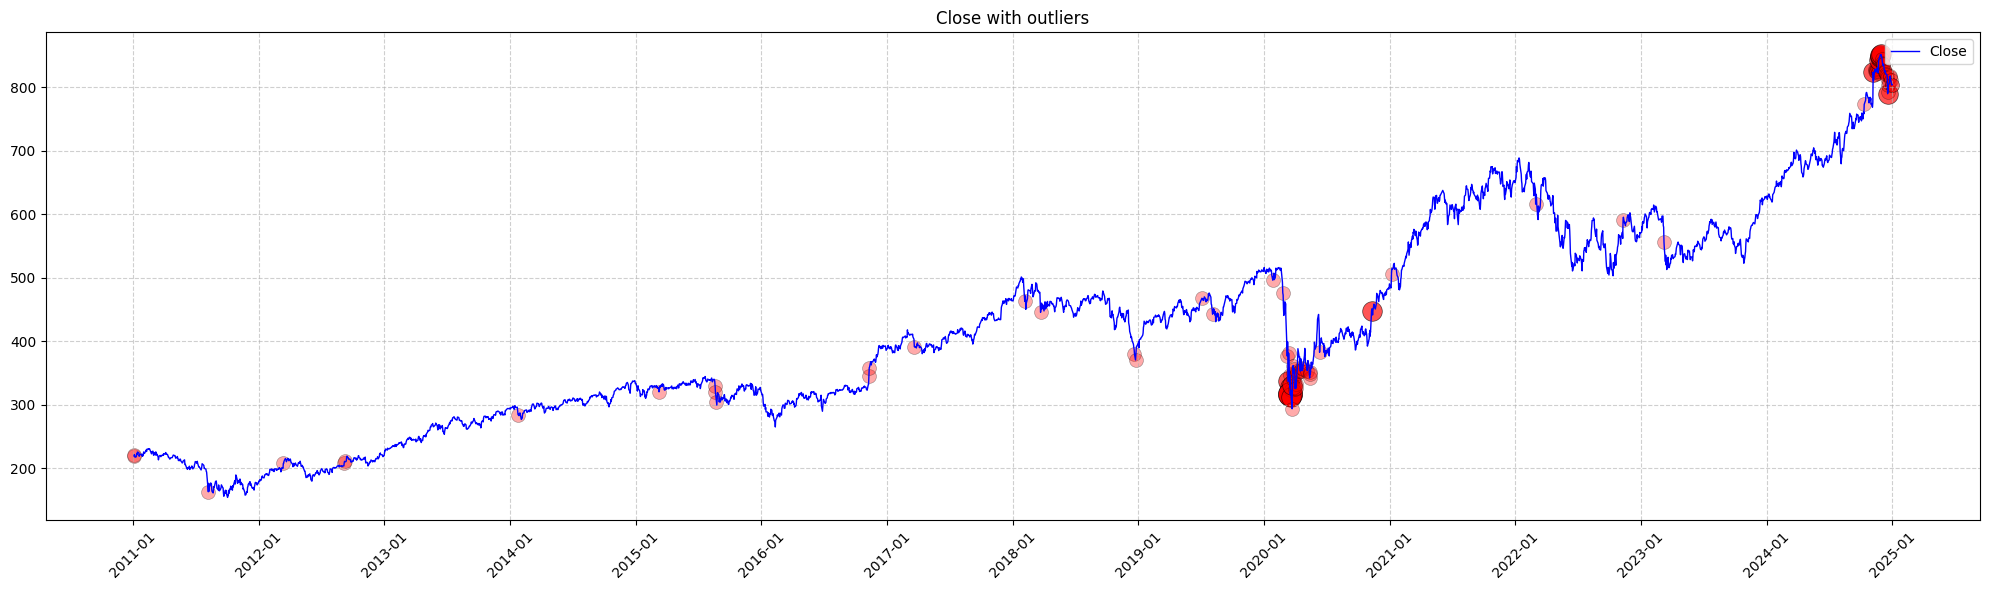

In [ ]:
plot_time_series_with_flags(ano_data, col='Close', agg_flags=agg_close)

# **2. Probability distribution analysis**

# **3. Hypothesis Testing**

# **4. Correlation Analysis**

# **5. Multiple Linear Regression**